

Now we try to use the French model to generate Spanish female names. Therefore, we feed the Spanish dataset in this model, conduct the same process, and see the result.


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


https://vocab.chat/blog/french-female-names.html#list-of-names

In [2]:
file_path = '/content/drive/MyDrive/ASS 2/Spanish.csv'

words = open(file_path, 'r').read().lower(). splitlines()
words[:8]

['maria carmen',
 'maria',
 'carmen',
 'josefa',
 'isabel',
 'ana maria',
 'maria pilar',
 'maria dolores']

In [3]:
len(words)

24756

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: ' ', 2: "'", 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'k', 14: 'l', 15: 'm', 16: 'n', 17: 'o', 18: 'p', 19: 'q', 20: 'r', 21: 's', 22: 't', 23: 'u', 24: 'v', 25: 'w', 26: 'x', 27: 'y', 28: 'z', 29: 'ç', 30: 'ñ', 0: '.'}


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([234675, 3]) torch.Size([234675])
torch.Size([29371, 3]) torch.Size([29371])
torch.Size([29158, 3]) torch.Size([29158])


In [6]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((33, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 33), generator=g)
b2 = torch.randn(33, generator=g)
parameters = [C, W1, b1, W2, b2]

In [7]:
sum(p.nelement() for p in parameters) # number of parameters in total

13163

In [8]:
for p in parameters:
  p.requires_grad = True

In [9]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [10]:
lri = []
lossi = []
stepi = []

In [11]:
for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad

    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
    #print(loss.item())

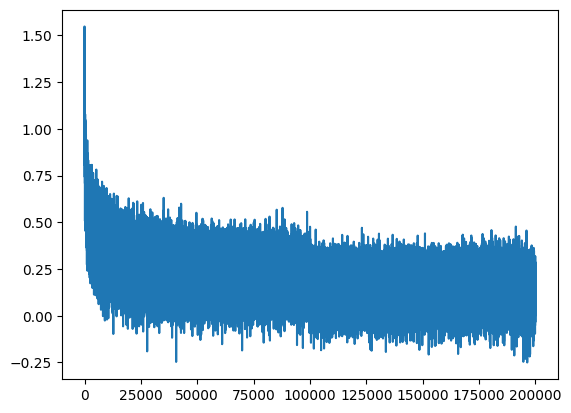

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.4263, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(1.5165, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(1.5297, grad_fn=<NllLossBackward0>)

KeyError: 31

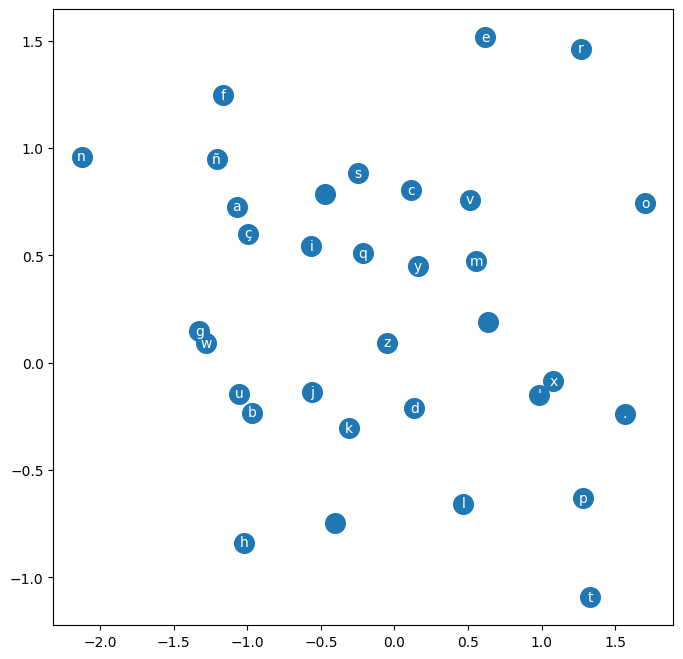

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

KeyError: 31, suggests that the index 31 is not found in itos (index-to-string) dictionary. This means that the index we're trying to access in itos is out of range or missing. Basically, there are 31 positions for index, but in reality, we only have 28 characters in the French input. The two "." and " " fills in two more indexes, leading to one empty index not found. In Spanish, However, it's the other way: there are too many characters (31) and not enough indexes, therefore we could not even get to the step of prediction.

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

cristina montserly.
dora.
stasa.
anie.
jyaquela bernacione.
maria.
carmelo altina.
amaria almudenta.
vivia yaizabeth.
monverona marineth.
paolastoume.
isa.
ziqin.
blasa luisabelsa.
sonia.
maria.
asuncion mirindy vidolorimita.
naya.
miren vally andra angela teres josefarolina.
nateres margaria teres.


In [ ]:
correct = 0
total = 0

# Evaluate on the validation set
for i in range(Xdev.shape[0]):
    emb = C[Xdev[i]]  # (block_size, embedding_dim)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (1, hidden_dim)
    logits = h @ W2 + b2  # (1, num_classes)
    prediction = torch.argmax(logits, dim=1).item()
    if prediction == Ydev[i].item():
        correct += 1
    total += 1

accuracy = correct / total
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.5264035953832011
